# **Homework 5:** Automatic Differentiation

## Overview

In this homework we will build a tiny reverse-mode automatic differentiation library!

In [24]:
# Uncomment and run if using Colab!

#import urllib.request
#remote_url = 'https://gist.githubusercontent.com/gabehope/d3e6b10338a1ba78f53204fc7502eda5/raw/52631870b1475b5ef8d9701f1c676fa97bf7b300/hw5_support.py'
#with urllib.request.urlopen(remote_url) as remote, open('hw5_support.py', 'w') as local:
#  [local.write(str(line, encoding='utf-8')) for line in remote]

# Run me first!
from hw5_support import *

#### Python features
This homework makes use of a few fancy features in Python that are worth knowing about if you are unfamiliar.
- [Variable length arguments](https://book.pythontips.com/en/latest/args_and_kwargs.html) (e.g. `*args`)
- [List comprehensions](https://book.pythontips.com/en/latest/comprehensions.html#list-comprehensions) (e.g. `[a**2 for a in range(5)]`)
- [Magic methods](https://rszalski.github.io/magicmethods/) (e.g. `__add__`)


## Part 1: Forward-mode automatic differentiation

We'll start by developing an automatic differentiation class that uses *forward-mode automatic differentiation*.

Recall that for this version of automatic differentiaion each operation needs to keep track of the derivative of it's value with respect *each* original input. Since for every operation we need to store these extra pieces of data and functions for computing both the operation and its derivative, it makes sense to define a *class* to represent the result of an operation.

For example, if we want to make a class that represents the operation `c=a+b` our class needs several properties:
- `value`: The value of the operation (`c`)
- `forward_grads`: A dictionary that contains the derivatives with respect to each original input (e.g. ($\frac{dc}{da}$ and $\frac{dc}{db}$)).
- `func`: A function that computes the operation (`a+b`)
- `grads`: A function that *computes* the derivatives of the operation ($\frac{dc}{da}$ and $\frac{dc}{db}$)

For this homework, we've provided the outline of such a class, called `ForwardValue`. This will be the base class for all of our possible operations and represents declaring a variable with a value (`a = 5`). This is useful because it lets us define values that we might want to find derivatives with respect to.

Let's see how this will work in practice. If we want to take derivatives we will first define the inputs using `ForwardValue`.

```{python}
a = ForwardValue(5)
b = ForwardValue(2)
```
Then we can perform whatever operations we want on these inputs:
```{python}
c = a + b
L = log(c)
```
Each of these operations will produce a new `ForwardValue` object representing the result of that operation.

As each result should maintain the derivatives with respect to each *original* inputs, we can access the final derivatives we're interested ($\frac{dL}{da}$ and $\frac{dL}{db}$) in from `L`.

```{python}
dL_da = L.forward_grads[a]
dL_db = L.forward_grads[b]
```


We'll also be able to compute operations with non-AutogradValue numbers, but obviously won't be able to compute derivaitives with respect to these values.
```{python}
s = 4
L = s * a
dL_da = L.forward_grads[a] # Will work because a is an ForwardValue
dL_ds = L.forward_grads[s] # Will give an error because s is not an ForwardValue
```

Now that we've seen what our final product will look like, let's define our `ForwardValue` class.

In [25]:
class AutogradValue:
    '''
    Base class for automatic differentiation operations. Represents variable delcaration.
    Subclasses will overwrite func and grads to define new operations.

    Properties:
        parents (list): A list of the inputs to the operation, may be AutogradValue or float
        parent_values    (list): A list of raw values of each input (as floats)
        forward_grads (dict): A dictionary mapping inputs to gradients
        grad    (float): The derivative of the final loss with respect to this value (dL/da)
        value   (float): The value of the result of this operation
    '''

    def __init__(self, *args):
        self.parents = list(args)
        self.parent_values = [arg.value if isinstance(arg, AutogradValue) else arg for arg in args]
        self.forward_grads = {}
        self.value = self.forward_pass()
        self.grad = 0. # Used later for reverse mode

    def func(self, input):
        '''
        Compute the value of the operation given the inputs.
        For declaring a variable, this is just the identity function (return the input).

        Args:
            input (float): The input to the operation
        Returns:
            value (float): The result of the operation
        '''
        return input

    def grads(self, *args):
        '''
        Compute the derivative of the operation with respect to each input.
        In the base case the derivative of the identity function is just 1. (da/da = 1).

        Args:
            input (float): The input to the operation
        Returns:
            grads (tuple): The derivative of the operation with respect to each input
                            Here there is only a single input, so we return a length-1 tuple.
        '''
        return (1,)

    def forward_pass(self):
        # Calls func to compute the value of this operation
        return self.func(*self.parent_values)

    def __repr__(self):
        # Python magic function for string representation.
        return str(self.value)

class ForwardValue(AutogradValue):
    '''
    Subclass for forward-mode automatic differentiation. Initialized the forward_grads
    dict to include this value.
    '''

    def __init__(self, *args):
        super().__init__(*args)
        if len(self.forward_grads.keys()) == 0:
            self.forward_grads = {self: 1}

Note that in the base case, when we declare a variable the derivative with respect to itself is just 1 ($\frac{da}{da}=1$)
```{python}
da_da = a.forward_grads[a] # Will be 1
```

Now that we've defined the framework for an operation that can be used in automatic differentiation, we need to define some actual useful operations by subclassing `ForwardValue`

#### **Q1:** Defining operations
Fill out the `func` and `grads` methods of each subclass below. Recall that `func` should always return the result of the operation and `grads` should always return a `tuple` of the derivative with respect to each input.

***Hint:** Look at the `_add` and `_neg` examples as a template!*

### Answer

In [26]:
class _add(AutogradValue):
    def func(self, a, b):
        return a + b
    
    def grads(self, a, b):
        return 1., 1.

class _sub(AutogradValue):
    def func(self, a, b):
        return a - b
    
    def grads(self, a, b):
        return 1., -1.

class _neg(AutogradValue):
    def func(self, a):
        return -a
    
    def grads(self, a):
        return (-1.,)
    
class _mul(AutogradValue):
    def func(self, a, b):
        return a * b
    
    def grads(self, a, b):
        return b, a

class _div(AutogradValue):
    def func(self, a, b):
        return a / b
    
    def grads(self, a, b):
        return 1 / b, -a / (b * b)
    
class _exp(AutogradValue):
    def func(self, a):
        return math.exp(a)
    
    def grads(self, a):
        return (math.exp(a),)

class _log(AutogradValue):
    def func(self, a):
        return math.log(a)
    
    def grads(self, a):
        return (1 / a,)

Below, we'll define our basic functions and operators in terms of the operator classes we just wrote.

In [27]:
def exp(a):
    return _exp(a) if isinstance(a, AutogradValue) else math.exp(a)
def log(a):
    return _log(a) if isinstance(a, AutogradValue) else math.log(a)

# Note: Remember that above we defined a class for each type of operation
# so in this code we are overriding the basic operators for AutogradValue
# such that they construct a new object of the class corresponding to the
# given operation and return it.
# (You don't need to everything that's happening here to do the HW)
AutogradValue.exp = lambda a: _exp(a)
AutogradValue.log = lambda a: _log(a)
AutogradValue.__add__ = lambda a, b: _add(a, b)
AutogradValue.__radd__ = lambda a, b: _add(b, a)
AutogradValue.__sub__ = lambda a, b: _sub(a, b)
AutogradValue.__rsub__ = lambda a, b: _sub(b, a)
AutogradValue.__neg__ = lambda a: _neg(a)
AutogradValue.__mul__ = lambda a, b: _mul(a, b)
AutogradValue.__rmul__ = lambda a, b: _mul(b, a)
AutogradValue.__truediv__ = lambda a, b: _div(a, b)
AutogradValue.__rtruediv__ = lambda a, b: _div(b, a)

We should now be able to use our `ForwardValue` objects as if they are numbers!

In [28]:
a = ForwardValue(5)
b = ForwardValue(2)

print((a + 5) * b)
print(log(b))

test_operators(ForwardValue)

20
0.6931471805599453
Passed!


We see now that our `forward_pass` method needs to update `forward_grads` (e.g. to compute $\frac{dg}{da}$ and $\frac{dg}{db}$) using the `forward_grads` values of its parents (e.g. $\frac{dc}{da}$ and $\frac{dc}{db}$)

#### **Q2:** Defining forward-mode autodiff
Update the `forward_pass` method below for forward-mode automatic differentiation. This method should update the `forward_grads` property of the operation such that:
- `forward_grads` has an entry for every input that appears in `forward_grads` of *any* parent operation.
- If an input appears in more than 1 parent, make sure to *add* the gradients appropritately (if `g` has parents `b` and `c` then $\frac{dg}{da} = \frac{dg}{db}\frac{db}{da} + \frac{dg}{dc}\frac{dc}{da}$  )
- Parents that are not `AutogradValue` objects are ignored

If our `forward_pass` method is working correctly, we should have the following behaivior:

In [29]:
# Define our inputs as ForwardValue objects
a = ForwardValue(5)
b = ForwardValue(2)

# Perform operations
c = a * b
g = 3 * c + a


# We should have the following in the forward_grads property of c and d (note that the keys are ForwardValue objects!)
c.forward_grads = {a: 2, b: 5}  # dc/da and dc/db
g.forward_grads = {a: 3 * 2 + 1, b: 3 * 5} # dg/da = dg/dc dc/da + dg/da, dg/db = dg/dc dc/db

Implement the method below

In [30]:
def forward_pass(self):
    self.forward_grads = {}
    grads = self.grads(*self.parent_values)
                
    # Again iterate through pairs of parent, local derivative
    for node, grad  in zip(self.parents, grads):
        # Check if the parent has a forward_grads property
        if hasattr(node, 'forward_grads'):
            # Iterate through all inputs in the parents forward_grad dict. 
            # Add it to our forward_grads if we haven't yet and update it
            for key, value in node.forward_grads.items():
                if key not in self.forward_grads:
                    self.forward_grads[key] = 0
                self.forward_grads[key] += value * grad
                
    # Make sure to still return the operation's value
    return self.func(*self.parent_values)

# Overwrite the AutogradValue method so that operators still work
AutogradValue.forward_pass = forward_pass
test_forward_mode(ForwardValue)

Passed!


We can now take derivates of functions!

In [31]:
a = ForwardValue(5)
b = ForwardValue(2)
L = -log(5 *b + a)

dL_da = L.forward_grads[a]
dL_db = L.forward_grads[b]
print('dL/da = %.3f, dL/db = %.3f' % (dL_da, dL_db))

dL/da = -0.067, dL/db = -0.333


We could also implement our own very simple version of Autograd's `grad`.

In [32]:
def grad(f):
    def ad_function(x, *args):
        x = ForwardValue(x)
        output = f(x, *args)
        return output.forward_grads[x]
    return ad_function

# Define a function
def f(x):
    return x * x

# Use 'grad' to compute the derivative function
f_prime = grad(f)

# Verify that we get the correct answer
x = 5.
print('x:\t', x)
print('f(x):\t', f(x))
print("f'(x):\t", f_prime(x))

x:	 5.0
f(x):	 25.0
f'(x):	 10.0


## Part 2: Reverse-mode automatic differentiation

We'll start by developing an automatic differentiation class that uses *reverse-mode automatic differentiation*, as this is what will be most useful for neural networks.

Recall that for reverse-mode AD to work, everytime we perform an operation on one or more numbers we need to store the result of that operation as well as the *parent values* (the inputs to the operation). We also need to be able to compute the derivative of that operation. Since for every operation we need to store several pieces of data and several functions, just like forward-mode automactic differentiation, it makes sense to define a class to represent the result of an operation.

In this case, we'll reuse the `AutogradValue` class we defined above as the the base class. The set of properties will be the same, except that instead of keeping track of a `forward_grads` dictionary, we'll keep track of a new `grad` property.
- `grad`: The derivative of the final loss with respect to `c` ($\frac{dL}{dc}$)

Remember that this will be the base class for all of our possible operations and represents declaring a variable with a value (`a = 5`).

Let's see how this will work in practice. If we want to take derivatives using reverse-mode, we will first define the inputs using `AutogradValue`.

```{python}
a = AutogradValue(5)
b = AutogradValue(2)
```
As before, we can perform whatever operations we want on these inputs:
```{python}
c = a + b
L = log(c)
```
Each of these operations will produce a new `AutogradValue` object representing the result of that operation.

Finally we can run the backward pass by running a method `backward()` (that we will write) on the outout `L`. This will compute the gradients of  `L` with respect to each input that we defined ($\frac{dL}{da}$ and $\frac{dL}{db}$). Rather than returning these derivatives, the `backward()` method will *update* the `grad` property of `a` and `b`, making it easy to access the correct derivative.

```{python}
L.backward()
dL_da = a.grad
```

Again, we'll be able to compute operations with non-AutogradValue numbers, but won't be able to compute derivaitives with respect to these values.
```{python}
s = 4
L = s * a
dL_da = a.grad # Will work because a is an AutogradValue
dL_ds = s.grad # Will give an error because s is not an AutogradValue
```

Now that we've seen what our final produce will look like, let's define our `AutogradValue` class.

Let's confirm that we do keep the entire compuational graph for operations defined in this way.

#### **Q3:** Computational graph
Write a function `graph_print` that takes a single argument. If the argument is an `AutogradValue` (or one of its subclasses), print its `value` property and then call `graph_print` on each of its parents. If the argument is not an `AutogradValue`, just print it. The format of printing is not important.

***Hint:** You can use the built-in Python function `isinstance` to determine if something is an `AutogradValue` or one of its subclasses. e.g. `isinstance(a, AutogradValue)`*

In [33]:
def graph_print(a):
    # Check if we're an AutogradValue
    if isinstance(a, AutogradValue):
        # Recursively call on each parent
        for p in a.parents:
            graph_print(p)
        print(a.value)
    else:
        print(a)

a = AutogradValue(5.)
b = AutogradValue(2.)
c = log((a + 5) * b)
graph_print(c)

5.0
5.0
5
10.0
2.0
2.0
20.0
2.995732273553991


The function should print (it's ok if the numbers or order aren't exact):
```
2.995732273553991
20.0
10.0
5.0
5.0
5
2.0
2.0
```

Now in order to do automatic differentiation, we need to define how to do the backward pass. We'll start with the backward_step for a single operation.

#### **Q4:** Backward pass
Fill in the method `backward_pass` which computes a single step of the reverse pass through the computational graph (assume `self` is an `AutogradValue` instance). If `backward_pass` is called on a value `c`, the method should:
- Assume that `self.grad` contains the derivaive of the final loss with respect to `c` ($\frac{dL}{dc}$).
- Check if each parent of `c`  is an `AutogradValue`. If it is, update that parent's `grad` property to account for `c` (e.g. for parent `a`, update the value of $\frac{dL}{da}$)

**For example:** if `c` represents the result of an addition so `c = a + b`,
calling `backward_pass` on `c` will update the `grad` property of both `a` and `b`. (`a.grad` represents $\frac{dL}{da}$ and is initialized to `0`).

***Hint:** `grads` will be one of the methods we wrote in the last homework (and shown above). Recall that if `c` has parents `a` and `b` then `grads` method will give $\frac{dc}{da}$ and $\frac{dc}{db}$.*

In [34]:
def backward_pass(self):
    local_grads = self.grads(*self.parent_values)

    # Loop through pairs of parents and their corresponding grads
    for node, grad in zip(self.parents, local_grads):
        # Update the gradient of each AutogradValue parent
        if isinstance(node, AutogradValue):
            node.grad += self.grad * grad


AutogradValue.backward_pass = backward_pass

# Test our implementation
test_backward_pass(AutogradValue)

Passed!


Finally we need to define the backward method itself. We will call this on the loss value to find the derivatives of the loss with respect to each input. This means working our way backward through the sequence of operations. Remember that if `c=a+b`, then if `c.grad` is $\frac{dL}{dc}$, calling `backward_pass` on `c` will update $\frac{dL}{da}$ (`a.grad`) and $\frac{dL}{db}$ (`b.grad`).

The complication is that `c` may be used in multiple operations, so we can't call `backward_pass` on `c` until we've called `backward_pass` on each child operation of `c` otherwise `c.grad` won't have the correct value of $\frac{dL}{dc}$, as in this example:

```{python}
c = a + b
g = c * 2
h = c + 4
L = g * h

L.backward_pass() # Updates dL/dg and dL/dh
h.backward_pass() # Updates dL/dc

##WRONG ORDER
c.backward_pass() # Incorrect because dL/dc hasn't accounted for dL/dg
g.backward_pass()

## CORRECT ORDER
g.backward_pass() # Updates dL/dc
c.backward_pass() # Updates dL/da and dL/db
```

#### **Q5:** Backward method
Fill in the `backward` method for `AutogradValue`. Your backward method should call `backward_pass` on each operation used to compute the loss (`self` is the loss value). Some important things to keep in mind:
- `backward_pass` should only be called **once** on each operation
- `backward_pass` must be called on **every child** of an operation before it can be called on the operation.
- You should not try to call `backward_pass` on values that aren't instances of `AutogradValue`, even though they might be stored in `operation.parents`

***Hint:** We discussed a simple approach to this problem in class! In general the problem we're solving here is a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting). We won't score efficiency in grading, but it still might be worth optimizing this function a bit.*

**Simple, but slow implementation**

In [35]:
def backward(self):
    # We call backward on the loss, so dL/dL = 1
    self.grad = 1.

    # Setup a queue of nodes to visit, starting with self (the final loss)
    queue = [self]
    # Setup a list keep track of the order to call backward_pass()
    order = []

    # Visit each AutogradValue in the queue
    while len(queue) > 0:
        node = queue.pop()
        if isinstance(node, AutogradValue):

            # We only want to keep the last instance of each node in the
            # order, so if we visit a node already in the order, remove it
            if node in order:
                order.remove(node)

            # Add the node to the end of the order and its paraent to the queue
            order.append(node)
            queue.extend(node.parents)
    
    # Once we have the order call backward pass on every node
    for node in order:
        node.backward_pass()

AutogradValue.backward = backward
# Test our implementation
test_backward(AutogradValue)

Passed!


**Faster implementation by keeping track of visit counts**

In [36]:
def backward(self):
    # We call backward on the loss, so dL/dL = 1
    self.grad = 1.
    queue = [self]
    order = []

    # Additionally keep track of the visit counts for each node
    counts = {}
    while len(queue) > 0:
        node = queue.pop()
        
        # Rather than removing nodes from the order [slow, O(N)], 
        # just mark that it has been visited again [O(1)]
        if isinstance(node, AutogradValue):
            if node in counts:
                counts[node] += 1
            else:
                counts[node] = 1

            order.append(node)
            queue.extend(node.parents)
    
    # Go through the order, but only call backward pass once we're at
    # the last vist for a given node
    for node in order:
        counts[node] -= 1
        if counts[node] == 0:
            node.backward_pass()

AutogradValue.backward = backward
# Test our implementation
test_backward(AutogradValue)

Passed!


Now we can use our `AutogradValue` class to compute derivatives!

In [37]:
a = AutogradValue(5)
b = AutogradValue(2)

L = -log(5 *b + a)
L.backward()
print(a.grad, b.grad)

-0.06666666666666667 -0.3333333333333333


If we want to train a neural network using our automatic differentiation implementation, we're going to want to be able to use numpy to do matrix operations. Fortunately, the our `AutogradValue` class is (mostly) compatible with numpy!

We can create arrays of `AutogradValue` and take derivatives as shown below:

In [38]:
a = np.asarray([AutogradValue(5), AutogradValue(2)])
L = np.dot(a, a)
L.backward()
print('Gradient for a', a[0].grad, a[1].grad)

Gradient for a 10.0 4.0


It would be a bit tedious to define every AutogradValue array in this way, so let's write some convinience functions to make doing automatic differentiation with numpy easier.

#### **Q6:** Array support
Complete the following two functions `wrap_array` and `unwrap_gradient`.

`wrap_array` should take a numpy array of floats and return a new array where every element has been made into an `AutogradValue`.

`unwrap_gradient` should take a numpy array of `AutogradValue` and return a new array of floats, where every element is the extracted `grad` property of the corresponding element from the original array.

Both of these functions should work on 2-D arrays (matrices) at a minimum (but more general solutions that support 1 and/or >2 dimensional arrays are also possible).

***Hint:** You can create an array from nested lists as `np.asarray([[1, 2], [3, 4]])`.*

**We'll start by creating a function that applys a function to each element of an array**

In [39]:
def element_map(f, a):
    '''
    Creates a new array the same shape as a, with a function f applied to each element.

    Args:
        a (function): The function to apply
        a (array): The array to map
    Returns:
        g (array): An array g, such that g[i,j] = f(a[i,j])
    '''

    # Store the original shape
    shape = a.shape
    
    # Create a 1-d array with the same elements using flatten()
    # then iterate through applying f to each element
    flat_wrapped = np.asarray([f(ai) for ai in a.flatten()])

    # Reshape back to the original shape
    return flat_wrapped.reshape(shape)

**We can use our `element_map` function to implement both wrapping and unwrapping**

In [40]:
def wrap_array(a):
    '''
    Wraps the elements of an array with AutogradValue

    Args:
        a (array of float): The array to wrap
    Returns:
        g (array of AutogradValue): An array g, such that g[i,j] = AutogradValue(a[i,j])
    '''
    return element_map(AutogradValue, a)
    

def unwrap_gradient(a):
    '''
    Unwraps the gradient of an array with AutogradValues

    Args:
        a (array of AutogradValue): The array to unwrap
    Returns:
        g (array of float): An array g, such that g[i,j] = a[i,j].grad
    '''
    return element_map(lambda ai: ai.grad, a)


test_wrap_unwrap(wrap_array, unwrap_gradient, AutogradValue)

Passed!


## Part 2: Training a neural network

Now we're ready to test out our `AutogradValue` implementation in the context it's designed for: neural networks! Below is a (slightly modified) version of the neural network class we wrote for the last homework.

In [41]:

def pad(a):
    # Pads an array with a column of 1s (for bias term)
    return a.pad() if isinstance(a, AutogradValue) else np.pad(a, ((0, 0), (0, 1)), constant_values=1., mode='constant')

def matmul(a, b):
    # Multiplys two matrices
    return _matmul(a, b) if isinstance(a, AutogradValue) else np.matmul(a, b)

def sigmoid(x):
    # Computes the sigmoid function
    return 1. / (1. + (-x).exp()) if isinstance(x, AutogradValue) else 1. / (1. + np.exp(-x))

class NeuralNetwork:
    def __init__(self, dims, hidden_sizes=[]):
        # Create a list of all layer dimensions (including input and output)
        sizes = [dims] + hidden_sizes + [1]
        # Create each layer weight matrix (including bias dimension)
        self.weights = [np.random.normal(scale=1., size=(i + 1, o))
                        for (i, o) in zip(sizes[:-1], sizes[1:])]

    def prediction_function(self, X, w):
        '''
        Get the result of our base function for prediction (i.e. x^t w)

        Args:
            X (array): An N x d matrix of observations.
            w (list of arrays): A list of weight matrices
        Returns:
            pred (array): An N x 1 matrix of f(X).
        '''
        # Iterate through the weights of each layer and apply the linear function and activation
        for wi in w[:-1]:
            X = pad(X) # Only if we're using bias
            X = sigmoid(matmul(X, wi))

        # For the output layer, we don't apply the activation
        X = pad(X)
        return matmul(X, w[-1])

    def predict(self, X):
        '''
        Predict labels given a set of inputs.

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            pred (array): An N x 1 column vector of predictions in {0, 1}
        '''
        return (self.prediction_function(X, self.weights) > 0)

    def predict_probability(self, X):
        '''
        Predict the probability of each class given a set of inputs

        Args:
            X (array): An N x d matrix of observations.
        Returns:
            probs (array): An N x 1 column vector of predicted class probabilities
        '''
        return sigmoid(self.prediction_function(X, self.weights))

    def accuracy(self, X, y):
        '''
        Compute the accuracy of the model's predictions on a dataset

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
        Returns:
            acc (float): The accuracy of the classifier
        '''
        y = y.reshape((-1, 1))
        return (self.predict(X) == y).mean()

    def nll(self, X, y, w=None):
        '''
        Compute the negative log-likelihood loss.

        Args:
            X (array): An N x d matrix of observations.
            y (array): A length N vector of labels.
            w (array, optional): A (d+1) x 1 matrix of weights.
        Returns:
            nll (float): The NLL loss
        '''
        if w is None:
            w = self.weights

        y = y.reshape((-1, 1))
        xw = self.prediction_function(X, w)
        py = sigmoid((2 * y - 1) * xw)
        return -(np.log(py)).sum()

#### **Q7:** Autograd for a neural network
Implement an `nll_and_grad` method for the `NeuralNetwork` class using your reverse-mode automatic differentiation implmentation to compute the gradient with respect to each weight matrix.



In [42]:
def nll_and_grad(self, X, y):
    '''
    Get the negative log-likelihood loss and its gradient

    Args:
        X (array): An N x d matrix of observations.
        y (array): A length N vector of labels
    Returns:
        nll (float): The negative log-likelihood
        grads (list of arrays): A list of the gradient of the nll with respect
                                to each value in self.weights.
    '''
    # Wrap the array we want to differentiate with respect to (weights)
    w = [wrap_array(wi) for wi in self.weights]

    # Run the NLL function and call backward to populate the gradients
    nll = self.nll(X, y, w)
    nll.backward()

    # Get both the nll value and graident
    return nll.value, [unwrap_gradient(wi) for wi in w]

NeuralNetwork.nll_and_grad = nll_and_grad

We now have everything in place to train a neural network from scratch! Let's try it on our tiny dataset. Feel free to change the inputs.

***Hint**: If this give very poor results and/or runs very slowly, make sure to carefully check the shape of each operation in your code to make sure it matches your expectation.*

Loss 11.25, accuracy: 0.95: 100%|██████████| 250/250 [00:40<00:00,  6.24it/s]


Model accuracy: 0.950


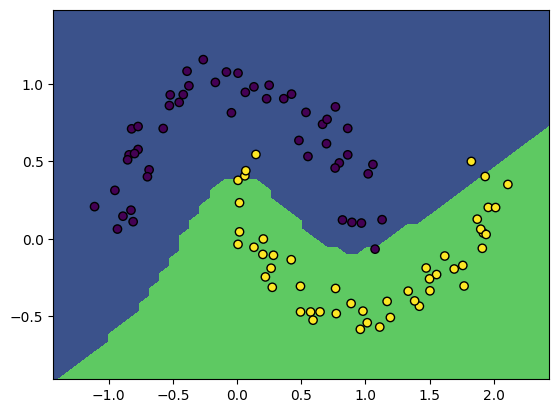

In [43]:
X, y = make_moons(100, noise=0.1)
model = NeuralNetwork(2, [10, 10])
gradient_descent(model, X, y, lr=3e-2, steps=250)

print('Model accuracy: %.3f' % model.accuracy(X, y))
plot_boundary(model, X, y)